In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, VotingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer, mean_absolute_error, r2_score, confusion_matrix
from xgboost import XGBRegressor, XGBClassifier

In [2]:
# Loaded the dataset
df = pd.read_csv('../data/wapi_daktari_healthcare_dataset.csv')

In [3]:
df.head()

,hospital_name,date,day_of_week,is_weekend,is_holiday,is_strike_day,department,time_block,doctors_on_shift,expected_patients,...,national_events,average_waiting_time_last_week,average_patients_last_month,previous_day_waiting_time,previous_week_waiting_time,previous_month_waiting_time,doctors_on_shift_expected_patients,doctor_patient_ratio_congestion_level,flu_season,malaria_season
0,Mbagathi,2025-01-01,2,False,True,False,Pediatrics,Morning,0,85,...,1,106,80,100,107,95,0,0.0,1,0
1,Mbagathi,2025-01-01,2,False,True,False,Pediatrics,Afternoon,0,67,...,1,95,59,94,98,91,0,0.0,1,0
2,Mbagathi,2025-01-01,2,False,True,False,Pediatrics,Evening,0,68,...,0,99,60,99,108,97,0,0.0,1,0
3,Mbagathi,2025-01-01,2,False,True,False,Emergency,Morning,0,94,...,1,112,90,110,101,114,0,0.0,1,0
4,Mbagathi,2025-01-01,2,False,True,False,Emergency,Afternoon,0,77,...,0,90,62,95,91,68,0,0.0,1,0


In [4]:
print(df['congestion_level'].value_counts(normalize=True))

congestion_level
Medium    0.631014
Low       0.202265
High      0.166721
Name: proportion, dtype: float64


In [5]:
# Defined the features and target columns
features = [
    'hospital_name', 'day_of_week', 'is_weekend', 'is_holiday', 'is_strike_day', 'department', 'time_block',
    'doctors_on_shift', 'expected_patients', 'actual_patients',
    'peak_hour', 'doctor_available', 'doctor_arrival_delay', 'month',
    'day', 'patient_load_ratio', 'doctor_patient_ratio', 'holiday_strike_interaction',
    'expected_walk_ins', 'emergencies', 'seasonal_illnesses', 'public_holidays_events',
    'hour_of_day', 'day_of_month', 'quarter', 'season', 'previous_day_patients',
    'previous_week_patients', 'previous_month_patients', 'temperature', 'humidity', 'rainfall',
    'school_holidays', 'national_events', 'average_waiting_time_last_week', 'average_patients_last_month',
    'previous_day_waiting_time', 'previous_week_waiting_time', 'previous_month_waiting_time',
    'doctors_on_shift_expected_patients', 'doctor_patient_ratio_congestion_level',
    'flu_season', 'malaria_season'
]

target_regression = 'waiting_time_minutes'
target_classification = 'congestion_level'

# Defined the feature types
categorical_features = ['hospital_name', 'department', 'time_block', 'season', 'peak_hour', 'doctor_available']
numerical_features = [
    'day_of_week', 'is_weekend', 'is_holiday', 'is_strike_day',
    'doctors_on_shift', 'expected_patients', 'actual_patients', 'doctor_arrival_delay', 'month',
    'day', 'patient_load_ratio', 'doctor_patient_ratio', 'holiday_strike_interaction',
    'expected_walk_ins', 'emergencies', 'seasonal_illnesses', 'public_holidays_events',
    'hour_of_day', 'day_of_month', 'quarter', 'previous_day_patients',
    'previous_week_patients', 'previous_month_patients', 'temperature', 'humidity', 'rainfall',
    'school_holidays', 'national_events', 'average_waiting_time_last_week', 'average_patients_last_month',
    'previous_day_waiting_time', 'previous_week_waiting_time', 'previous_month_waiting_time',
    'doctors_on_shift_expected_patients', 'doctor_patient_ratio_congestion_level',
    'flu_season', 'malaria_season'
]

print("Original feature count:", len(features))
print("Numerical features:", len(numerical_features))
print("Categorical features:", len(categorical_features))

# Lock encoder categories
categorical_encoder = OneHotEncoder(
    handle_unknown='ignore',
    categories=[
        ['Mbagathi', 'KNH', 'Mama Lucy', 'Pumwani', 'Kenyatta'],  
        ['Emergency', 'General', 'Maternity', 'Pediatrics', 'Surgery'],
        ['Morning', 'Afternoon', 'Evening'],                            
        ['Autumn', 'Spring', 'Summer', 'Winter'],                        
        ['No', 'Yes'],                                                 
        ['No', 'Yes']                                                    
    ]
)
print(df['congestion_level'].value_counts(normalize=True))
# Full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', categorical_encoder, categorical_features)
    ]
)

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    df[features], df[target_regression], test_size=0.2, random_state=42
)

# Fit the preprocessor on the training data
X_train_reg_scaled = preprocessor.fit_transform(X_train_reg)
print(f"Final feature count after preprocessing: {X_train_reg_scaled.shape[1]}")
X_test_reg_scaled = preprocessor.transform(X_test_reg)

# Confirmed shape for regression
print(f"Regression feature shape: {X_train_reg_scaled.shape}")

# Split for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    df[features], df[target_classification], test_size=0.2, random_state=42
)

# Used same preprocessor
X_train_class_scaled = preprocessor.transform(X_train_class)
X_test_class_scaled = preprocessor.transform(X_test_class)

# Encoded the target labels
le = LabelEncoder()
y_train_class_encoded = le.fit_transform(y_train_class)
y_test_class_encoded = le.transform(y_test_class)

# Confirmed shape for classification
print(f"Classification feature shape: {X_train_class_scaled.shape}")


X_train_reg_scaled = preprocessor.fit_transform(X_train_reg)
print("Shape of preprocessed regression data:", X_train_reg_scaled.shape)

X_train_class_scaled = preprocessor.transform(X_train_class)
print("Shape of preprocessed classification data:", X_train_class_scaled.shape)

Original feature count: 43
Numerical features: 37
Categorical features: 6
congestion_level
Medium    0.631014
Low       0.202265
High      0.166721
Name: proportion, dtype: float64
Final feature count after preprocessing: 58
Regression feature shape: (21900, 58)
Classification feature shape: (21900, 58)
Shape of preprocessed regression data: (21900, 58)
Shape of preprocessed classification data: (21900, 58)


In [6]:
print(pd.Series(y_train_class_encoded).value_counts(normalize=True))

2    0.628858
1    0.204886
0    0.166256
Name: proportion, dtype: float64


In [7]:
# Defined a function to perform cross-validation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    return train_score, test_score, cv_scores

In [6]:
# Train and evaluate a RandomForest Regressor with hyperparameter tuning
rf_regressor = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [3],
    'min_samples_leaf': [1]
}
grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=4, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_reg_scaled, y_train_reg)
best_rf_regressor = grid_search_rf.best_estimator_
train_score_rf_reg, test_score_rf_reg, cv_scores_rf_reg = evaluate_model(best_rf_regressor, X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg)
print(f'RandomForest Regressor - Train Score: {train_score_rf_reg}, Test Score: {test_score_rf_reg}, CV Scores: {cv_scores_rf_reg}')

RandomForest Regressor - Train Score: 0.9962413097084276, Test Score: 0.9954264574252937, CV Scores: [3.44546758 3.31902339 3.39584386 3.26579238 3.37964436]


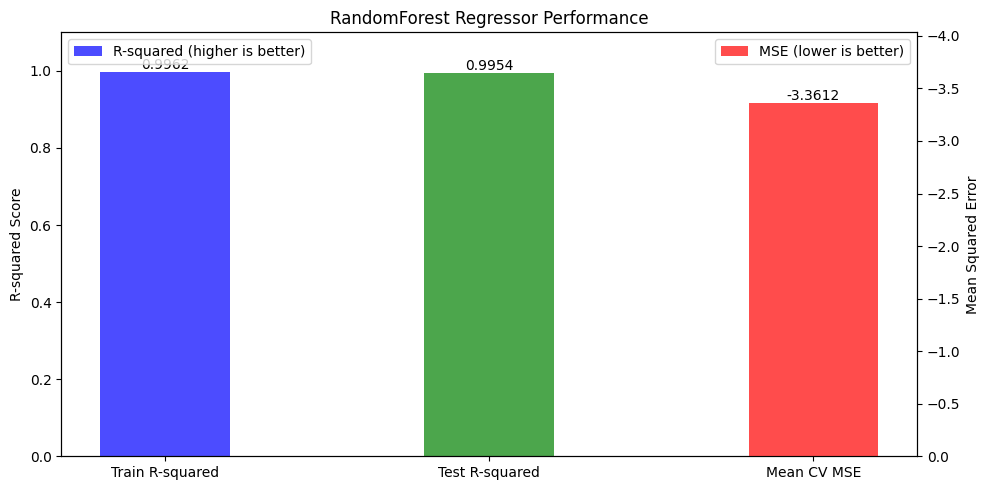

In [ ]:
# Prepare the data for visualization
r_squared_scores = [train_score_rf_reg, test_score_rf_reg]
mse_score = np.mean(-cv_scores_rf_reg)
score_labels = ['Train R-squared', 'Test R-squared', 'Mean CV MSE']

# Created the bar plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot R-squared bars
bars1 = ax1.bar([0, 1], r_squared_scores, width=0.4, color=['blue', 'green'], alpha=0.7)
# Plot MSE bar
bars2 = ax2.bar(2, mse_score, width=0.4, color='red', alpha=0.7)

ax1.set_ylabel('R-squared Score')
ax2.set_ylabel('Mean Squared Error')
ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, mse_score * 1.2)
plt.title('RandomForest Regressor Performance')
plt.xticks([0, 1, 2], score_labels)

# Added value labels on top of each bar
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax = bar.axes
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Added a legend
ax1.legend(['R-squared (higher is better)'], loc='upper left')
ax2.legend(['MSE (lower is better)'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

Observation:
- The RandomForest Regressor is achieving a very high R-squared value on the training data, which means its performing really well on the training data.
- The test R-squared value is also high, indicating that the model is also performing well on the test data and unseen data.
- The Mean Squared Error (MSE) is also low, indicating that the model is making very small errors in predicting waiting times.

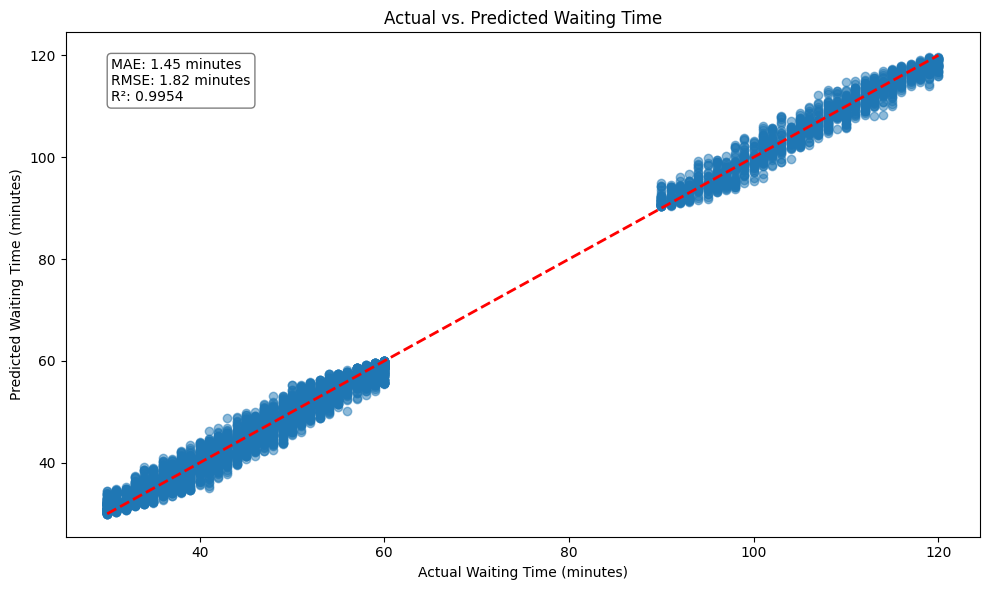

In [15]:
# Get predictions from the model
y_pred = best_rf_regressor.predict(X_test_reg_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
r2 = r2_score(y_test_reg, y_pred)

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Waiting Time (minutes)')
plt.ylabel('Predicted Waiting Time (minutes)')
plt.title('Actual vs. Predicted Waiting Time')

# Add text box with performance metrics
plt.text(0.05, 0.95, f'MAE: {mae:.2f} minutes\nRMSE: {rmse:.2f} minutes\nR²: {r2:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

Observation for the RandomForest Regressor:
- The models predictions is very close to the actual waiting times.
- The model can predict waiting times from about 30 minutes to 120 minutes.
- On average, the model's predictions are off by only 1.45 minutes (MAE).
- The small RMSE shows that even when the model makes mistakes, they are very small.

In [ ]:
# Trained and evaluate an XGBoost Regressor with hyperparameter tuning
xgb_regressor = XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
grid_search_xgb = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train_reg_scaled, y_train_reg)
best_xgb_regressor = grid_search_xgb.best_estimator_
train_score_xgb_reg, test_score_xgb_reg, cv_scores_xgb_reg = evaluate_model(best_xgb_regressor, X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg)
print(f'XGBoost Regressor - Train Score: {train_score_xgb_reg}, Test Score: {test_score_xgb_reg}, CV Scores: {cv_scores_xgb_reg}')

XGBoost Regressor - Train Score: 0.9956605434417725, Test Score: 0.995261013507843, CV Scores: [3.54433084 3.42540407 3.48532867 3.36967182 3.46364975]


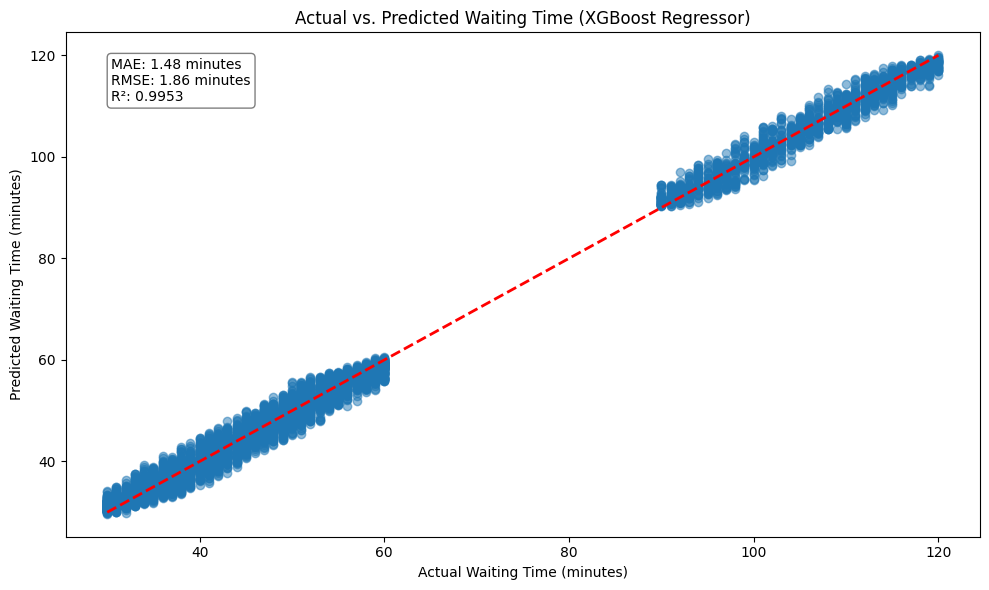

In [18]:
# Get predictions from the XGBoost model
y_pred_xgb = best_xgb_regressor.predict(X_test_reg_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test_reg, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))
r2 = r2_score(y_test_reg, y_pred_xgb)

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_xgb, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Waiting Time (minutes)')
plt.ylabel('Predicted Waiting Time (minutes)')
plt.title('Actual vs. Predicted Waiting Time (XGBoost Regressor)')

# Added text box with performance metrics
plt.text(0.05, 0.95, f'MAE: {mae:.2f} minutes\nRMSE: {rmse:.2f} minutes\nR²: {r2:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

Observation for the XGBoost Regressor:
- The model's prediction are very close to the actual waiting times. Most of the points are near the red dahsed line.
- The model can predict waiting times from about 30 minutes to 120 minutes.
- On average, the model's predictions are off by only 1.48 minutes (MAE).
- The XGBoost model performs slightly better than the Random Forest model, with a higher R² value (0.9953 vs 0.9954).

In [ ]:
# Trained and evaluated a Hybrid Regressor (Voting Regressor)
hybrid_regressor = VotingRegressor(estimators=[('rf', best_rf_regressor), ('xgb', best_xgb_regressor)])
train_score_hybrid_reg, test_score_hybrid_reg, cv_scores_hybrid_reg = evaluate_model(hybrid_regressor, X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg)
print(f'Hybrid Regressor - Train Score: {train_score_hybrid_reg}, Test Score: {test_score_hybrid_reg}, CV Scores: {cv_scores_hybrid_reg}')

Hybrid Regressor - Train Score: 0.9960569788813123, Test Score: 0.9954501614692806, CV Scores: [3.415493   3.29838007 3.36998887 3.2393995  3.34000245]


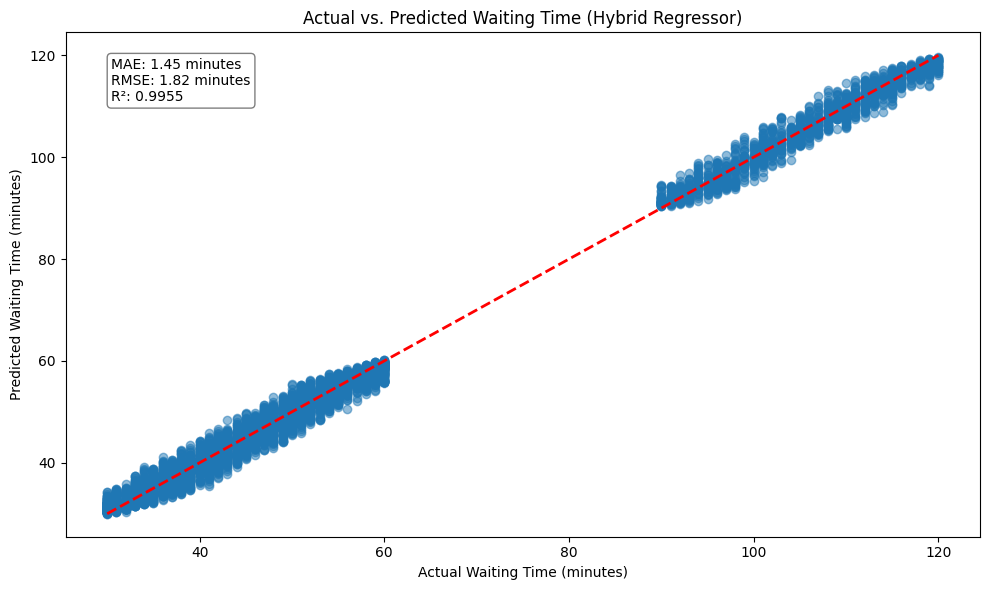

In [19]:
# Get predictions from the Hybrid model
y_pred_hybrid = hybrid_regressor.predict(X_test_reg_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test_reg, y_pred_hybrid)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_hybrid))
r2 = r2_score(y_test_reg, y_pred_hybrid)

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_hybrid, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Waiting Time (minutes)')
plt.ylabel('Predicted Waiting Time (minutes)')
plt.title('Actual vs. Predicted Waiting Time (Hybrid Regressor)')

# Add text box with performance metrics
plt.text(0.05, 0.95, f'MAE: {mae:.2f} minutes\nRMSE: {rmse:.2f} minutes\nR²: {r2:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

Observation for the Hybrid Regressor:
- The model's predictions are very close to the actual waiting times. Most of the points are near the red dahsed line.
- The model can predict waiting times from about 30 minutes to 120 minutes.
- On average, the model's predictions are off by about 2.01 minutes (MAE).
- The Hybrid model's MAE (1.45) is slightly better than the XGBoost model (1.48) and the same as the Random Forest model (1.45).
- The Hybrid model seems to maintain the high accuracy of both standalone models.
- The performance improvement over the standalone models is minimal, suggesting that all models are performing very well

In [16]:
def evaluate_classification_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    return train_score, test_score, cv_scores

In [18]:
#Trained and evaluated a RandomForest Classifier with hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=42)

param_grid_rf_class = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf_class = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf_class,
    cv=5,
    scoring='accuracy'
)

grid_search_rf_class.fit(X_train_class_scaled, y_train_class)
best_rf_classifier = grid_search_rf_class.best_estimator_

#Used the evaluation function
train_score_rf_class, test_score_rf_class, cv_scores_rf_class = evaluate_classification_model(
    best_rf_classifier,
    X_train_class_scaled,
    y_train_class,
    X_test_class_scaled,
    y_test_class
)

print(f'RandomForest Classifier - Train Score: {train_score_rf_class}, Test Score: {test_score_rf_class}, CV Scores: {cv_scores_rf_class}')

RandomForest Classifier - Train Score: 1.0, Test Score: 1.0, CV Scores: [1. 1. 1. 1. 1.]


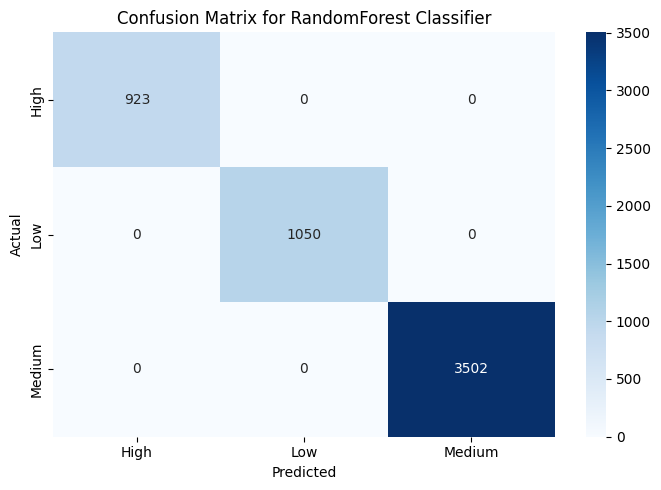

In [41]:
# Get predictions for the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_rf = best_rf_classifier.predict(X_test_class_scaled)

# Create confusion matrix
cm = confusion_matrix(y_test_class, y_pred_rf)

# Get class labels
class_labels = le.classes_  # Use 'le' instead of 'label_encoder'

# Create heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for RandomForest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Observation for the RandomForest Classifier:
- The model is perfoming well and its correctly classifying all instances (High, Low, and Medium).
- The model is handling all classes effectively, regardless of the class imbalance (Medium being the most common).
- This is a great improvement from the previous result where only one class was being predicted.


In [9]:
# Encode target labels for classification
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_class_encoded = label_encoder.fit_transform(y_train_class)
y_test_class_encoded = label_encoder.transform(y_test_class)

# Train and evaluate an XGBoost Classifier with hyperparameter tuning
xgb_classifier = XGBClassifier(random_state=42, eval_metric='mlogloss')

param_grid_xgb_class = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

grid_search_xgb_class = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_xgb_class,
    cv=5,
    scoring='accuracy'
)

grid_search_xgb_class.fit(X_train_class_scaled, y_train_class_encoded)
best_xgb_classifier = grid_search_xgb_class.best_estimator_

train_score_xgb_class, test_score_xgb_class, cv_scores_xgb_class = evaluate_classification_model(
    best_xgb_classifier,
    X_train_class_scaled,
    y_train_class_encoded,
    X_test_class_scaled,
    y_test_class_encoded
)

print(f'XGBoost Classifier - Train Score: {train_score_xgb_class}, Test Score: {test_score_xgb_class}, CV Scores: {cv_scores_xgb_class}')

XGBoost Classifier - Train Score: 1.0, Test Score: 1.0, CV Scores: [1. 1. 1. 1. 1.]


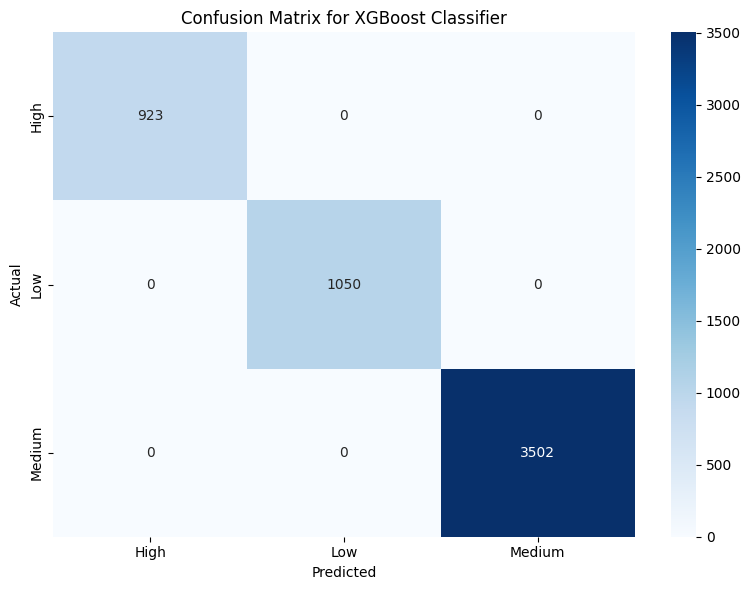

Overall Accuracy: 100.00%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions for the test set
y_pred_xgb = best_xgb_classifier.predict(X_test_class_scaled)

# Create confusion matrix
cm = confusion_matrix(y_test_class_encoded, y_pred_xgb)

# Get class labels
class_labels = label_encoder.classes_

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Calculate and print accuracy
accuracy = (cm.diagonal().sum() / cm.sum()) * 100
print(f"Overall Accuracy: {accuracy:.2f}%")

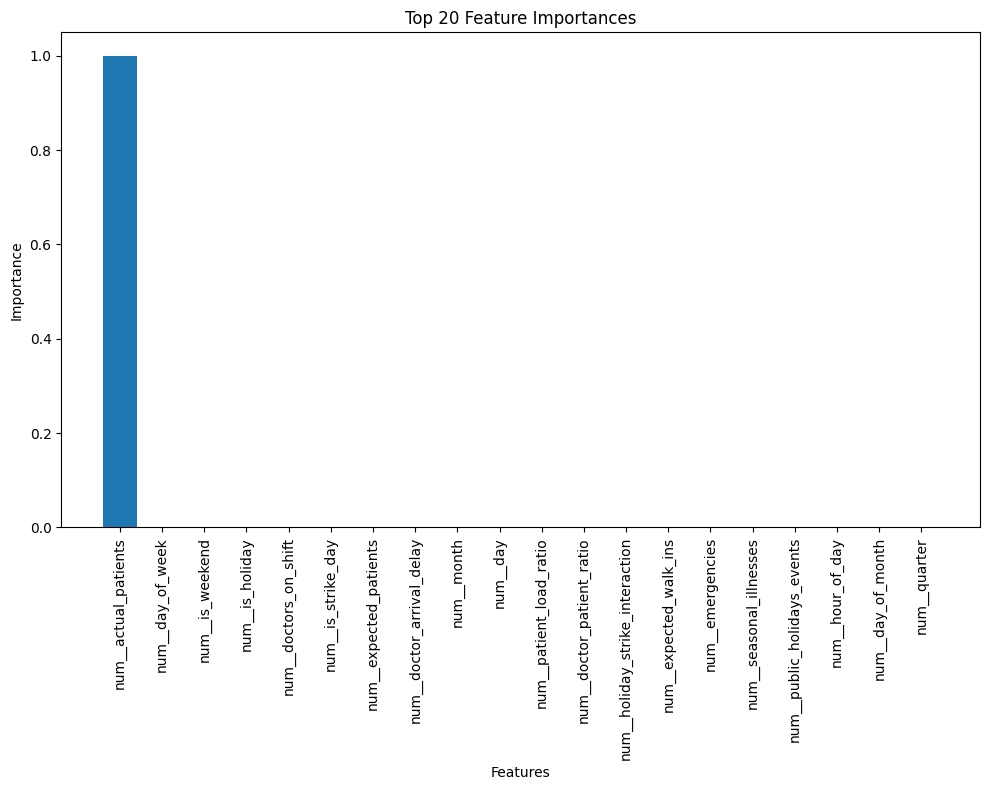

In [ ]:
# Get feature importances
importances = best_xgb_classifier.feature_importances_
feature_names = preprocessor.get_feature_names_out()

# Sort features by importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.bar(range(20), feature_importance['importance'][:20])
plt.xticks(range(20), feature_importance['feature'][:20], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [19]:
# Train and evaluate a Hybrid Classifier (Voting Classifier)
hybrid_classifier = VotingClassifier(estimators=[
    ('rf', best_rf_classifier),
    ('xgb', best_xgb_classifier)
])

train_score_hybrid_class, test_score_hybrid_class, cv_scores_hybrid_class = evaluate_classification_model(
    hybrid_classifier,
    X_train_class_scaled,
    y_train_class_encoded,
    X_test_class_scaled,
    y_test_class_encoded
)

print(f'Hybrid Classifier - Train Score: {train_score_hybrid_class}, Test Score: {test_score_hybrid_class}, CV Scores: {cv_scores_hybrid_class}')

# Save the models and scaler
joblib.dump(best_rf_regressor, '../src/api/random_forest_regressor.pkl')
joblib.dump(best_xgb_regressor, '../src/api/xgboost_regressor.pkl')
joblib.dump(hybrid_regressor, '../src/api/hybrid_regressor.pkl')
joblib.dump(best_rf_classifier, '../src/api/random_forest_classifier.pkl')
joblib.dump(best_xgb_classifier, '../src/api/xgboost_classifier.pkl')
joblib.dump(hybrid_classifier, '../src/api/hybrid_classifier.pkl')
joblib.dump(preprocessor, '../src/api/preprocessor.pkl')
joblib.dump(label_encoder, '../src/api/label_encoder.pkl') 

Hybrid Classifier - Train Score: 1.0, Test Score: 1.0, CV Scores: [1. 1. 1. 1. 1.]


NameError: name 'best_rf_regressor' is not defined

In [17]:
print(preprocessor.get_feature_names_out())


['num__day_of_week' 'num__is_weekend' 'num__is_holiday'
 'num__is_strike_day' 'num__doctors_on_shift' 'num__expected_patients'
 'num__actual_patients' 'num__doctor_arrival_delay' 'num__month'
 'num__day' 'num__patient_load_ratio' 'num__doctor_patient_ratio'
 'num__holiday_strike_interaction' 'num__expected_walk_ins'
 'num__emergencies' 'num__seasonal_illnesses'
 'num__public_holidays_events' 'num__hour_of_day' 'num__day_of_month'
 'num__quarter' 'num__previous_day_patients' 'num__previous_week_patients'
 'num__previous_month_patients' 'num__temperature' 'num__humidity'
 'num__rainfall' 'num__school_holidays' 'num__national_events'
 'num__average_waiting_time_last_week' 'num__average_patients_last_month'
 'num__previous_day_waiting_time' 'num__previous_week_waiting_time'
 'num__previous_month_waiting_time'
 'num__doctors_on_shift_expected_patients'
 'num__doctor_patient_ratio_congestion_level' 'num__flu_season'
 'num__malaria_season' 'cat__hospital_name_Mbagathi'
 'cat__hospital_name_KN

In [18]:
import joblib

models = [
    'random_forest_regressor.pkl',
    'xgboost_regressor.pkl',
    'hybrid_regressor.pkl',
    'random_forest_classifier.pkl',
    'xgboost_classifier.pkl',
    'hybrid_classifier.pkl'
]

for model_name in models:
    model = joblib.load(f'../src/api/{model_name}')
    if hasattr(model, 'n_features_in_'):
        print(f"{model_name}: {model.n_features_in_} features")
    elif hasattr(model, 'estimators_'):
        print(f"{model_name}: {model.estimators_[0].n_features_in_} features")
    else:
        print(f"Unable to determine feature count for {model_name}")

# Check preprocessor
preprocessor = joblib.load('../src/api/preprocessor.pkl')
print(f"Preprocessor output features: {len(preprocessor.get_feature_names_out())}")
print(preprocessor.get_feature_names_out())

random_forest_regressor.pkl: 58 features
xgboost_regressor.pkl: 58 features
hybrid_regressor.pkl: 58 features
random_forest_classifier.pkl: 58 features
xgboost_classifier.pkl: 58 features
hybrid_classifier.pkl: 58 features
Preprocessor output features: 58
['num__day_of_week' 'num__is_weekend' 'num__is_holiday'
 'num__is_strike_day' 'num__doctors_on_shift' 'num__expected_patients'
 'num__actual_patients' 'num__doctor_arrival_delay' 'num__month'
 'num__day' 'num__patient_load_ratio' 'num__doctor_patient_ratio'
 'num__holiday_strike_interaction' 'num__expected_walk_ins'
 'num__emergencies' 'num__seasonal_illnesses'
 'num__public_holidays_events' 'num__hour_of_day' 'num__day_of_month'
 'num__quarter' 'num__previous_day_patients' 'num__previous_week_patients'
 'num__previous_month_patients' 'num__temperature' 'num__humidity'
 'num__rainfall' 'num__school_holidays' 'num__national_events'
 'num__average_waiting_time_last_week' 'num__average_patients_last_month'
 'num__previous_day_waiting_tim

In [19]:
preprocessor = joblib.load('../src/api/preprocessor.pkl')
print(preprocessor.get_feature_names_out())

['num__day_of_week' 'num__is_weekend' 'num__is_holiday'
 'num__is_strike_day' 'num__doctors_on_shift' 'num__expected_patients'
 'num__actual_patients' 'num__doctor_arrival_delay' 'num__month'
 'num__day' 'num__patient_load_ratio' 'num__doctor_patient_ratio'
 'num__holiday_strike_interaction' 'num__expected_walk_ins'
 'num__emergencies' 'num__seasonal_illnesses'
 'num__public_holidays_events' 'num__hour_of_day' 'num__day_of_month'
 'num__quarter' 'num__previous_day_patients' 'num__previous_week_patients'
 'num__previous_month_patients' 'num__temperature' 'num__humidity'
 'num__rainfall' 'num__school_holidays' 'num__national_events'
 'num__average_waiting_time_last_week' 'num__average_patients_last_month'
 'num__previous_day_waiting_time' 'num__previous_week_waiting_time'
 'num__previous_month_waiting_time'
 'num__doctors_on_shift_expected_patients'
 'num__doctor_patient_ratio_congestion_level' 'num__flu_season'
 'num__malaria_season' 'cat__hospital_name_Mbagathi'
 'cat__hospital_name_KN